In [25]:
import cvxopt
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import cvxpy as cvx
import dccp
from glob import *

<img src="motivation.png" alt="Drawing" style="width: 800px;"/>
<img src="formulation.png" alt="Drawing" style="width: 800px;"/>
<img src="constraints.png" alt="Drawing" style="width: 800px;"/>

In [26]:

def frames_to_video(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''
    image_files = glob(input_path)
    #print(image_files)    
    
    image_files = glob(input_path)
    final = len(image_files)
    location = './plots_temp'  #./plots_temp_holo_wheel"
    frames = [] 
    for f in range(0 + 1, 1 + final):
#         print(f)
        frame = cv2.imread(f"{location}/{f}.png")
#         print(f"{location}/{f}.png")
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)
        if f == final:
            for endingFrame in range(5):
                frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

In [29]:
t_del = 1
v_init = np.array([10,10])

class MPC_Agent:
    
    def __init__(self, start, goal, steps, vmax):
        self.xpath = []
        self.ypath = []
        self.time = 0
        self.pos = start
        self.goal = goal
        self.v = np.array([0,0])
        self.steps = steps
        self.vmax = vmax
           
        
    def traj_opti(self):
       
        x = (t_del ** 2) * np.vstack((np.hstack((np.ones((self.steps, self.steps)), np.zeros((self.steps, self.steps)))), np.hstack((np.zeros((self.steps, self.steps)), np.ones((self.steps, self.steps))))))
        P = float(2) * cvxopt.matrix(x, tc = 'd')
        kx = self.pos[0] - self.goal[0]
        ky = self.pos[1] - self.goal[1]
        Q_mat_x = float(kx) * np.ones((self.steps,1))
        Q_mat_y = float(ky) * np.ones((self.steps,1))
        Q_mat = float(2.0 * t_del) * np.vstack((Q_mat_x, Q_mat_y))
        Q = cvxopt.matrix(Q_mat, tc = 'd')

        G_mat_x = np.zeros((4 * self.steps, 2 * self.steps))
        for i in range(0, self.steps):
            G_mat_x[i][i] = -1
            G_mat_x[i + self.steps][i] = 1
            G_mat_x[i + 2*self.steps][i+self.steps] = -1
            G_mat_x[i + 3*self.steps][i+self.steps] = 1
        H_mat_x = np.zeros((4 * self.steps, 1))
        
        for i in range(0, self.steps):
            H_mat_x[i] = 0
            H_mat_x[i + self.steps] = self.vmax
            H_mat_x[i + 2*self.steps] = 0
            H_mat_x[i + 3*self.steps] = self.vmax
        G = cvxopt.matrix(G_mat_x, tc = 'd')
        H = cvxopt.matrix(H_mat_x, tc = 'd')
        sol = cvxopt.solvers.qp(P,Q,G,H,options={'show_progress': False})
        
        if os.path.isdir("./plots_temp"):
            shutil.rmtree("./plots_temp")
        os.mkdir("./plots_temp")
     
    
        for i in range(0,self.steps):
            
            x_i = self.pos[0] + sol['x'][i] * t_del
            y_i = self.pos[1] + sol['x'][i + self.steps] * t_del
            
            
            print(sol['x'][i])
            print(sol['x'][i + self.steps])
            self.xpath.append(x_i.astype('float'))
            self.ypath.append(y_i.astype('float'))
            self.pos[0] = x_i
            self.pos[1] = y_i

            print('----------------------------------------------')
            self.time += 1
            print(self.time, self.pos[0], self.pos[1])
            self.visualize_traj() 
            
        frames_to_video("./plots_temp/*.png", "./Quadratic-programming-control.mp4", 10)
    
    
    def visualize_traj(self):
        
        plt.plot(self.pos[0], self.pos[1], '^',color = 'orangered', markersize = 20)
        plt.plot(self.goal[0], self.goal[1], '^',color = 'lawngreen', markersize = 20)
        plt.title("Timestamp " + str(self.time), fontsize = 20, color = 'green')
        
        x_path = np.array(self.xpath)
        y_path = np.array(self.ypath)
        plt.plot(x_path, y_path, color = 'gold')
#         plt.axis('off')
        plt.xticks(x_path, " ")
        plt.yticks(y_path, " ")
        plt.savefig("./plots_temp/" + str(self.time) + ".png")

        plt.show()
   

0.350000074534626
0.6000000359802307
----------------------------------------------
1 1.3500000745346261 1.6000000359802307


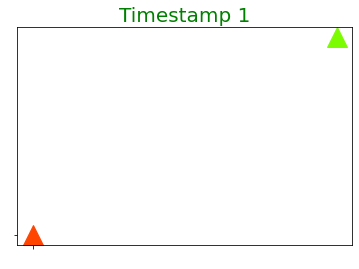

0.35000007453462667
0.6000000359616041
----------------------------------------------
2 1.7000001490692527 2.200000071941835


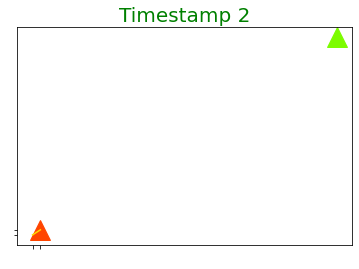

0.3500000745346267
0.6000000359614123
----------------------------------------------
3 2.0500002236038792 2.800000107903247


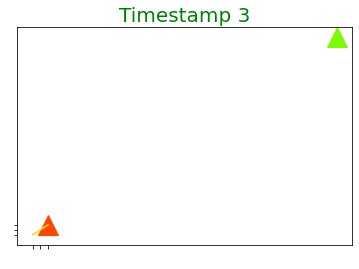

0.3500000745346261
0.6000000359614137
----------------------------------------------
4 2.4000002981385054 3.400000143864661


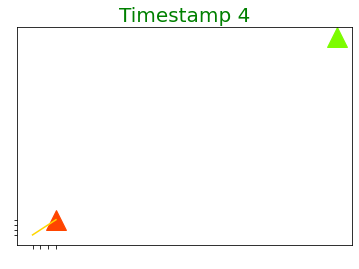

0.3500000745346258
0.6000000359612256
----------------------------------------------
5 2.750000372673131 4.000000179825887


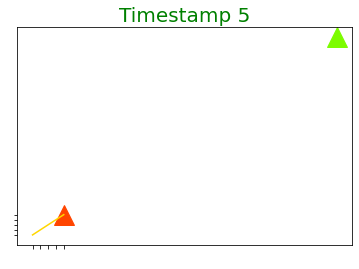

0.3500000745346603
0.6000000359612266
----------------------------------------------
6 3.1000004472077913 4.600000215787113


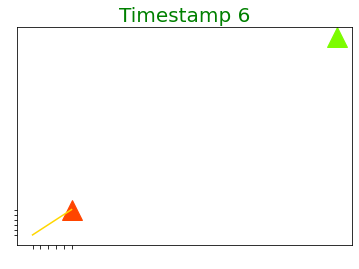

0.35000007453462567
0.6000000359612264
----------------------------------------------
7 3.450000521742417 5.20000025174834


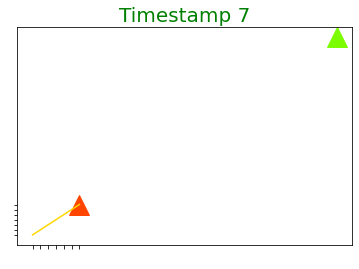

0.3500000745346601
0.6000000359612273
----------------------------------------------
8 3.8000005962770773 5.800000287709567


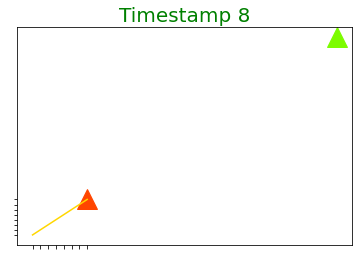

0.35000007453466125
0.6000000359614145
----------------------------------------------
9 4.150000670811739 6.400000323670982


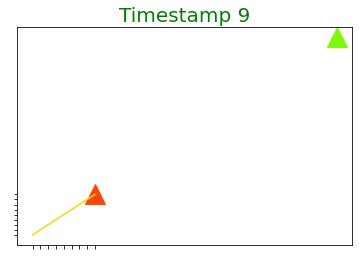

0.3500000745346614
0.6000000359614128
----------------------------------------------
10 4.500000745346401 7.000000359632395


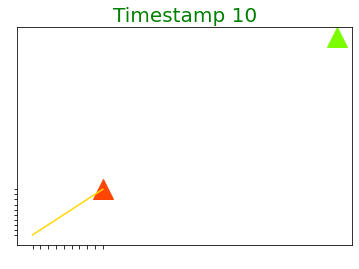

0.3500000745346611
0.6000000359614162
----------------------------------------------
11 4.850000819881061 7.600000395593812


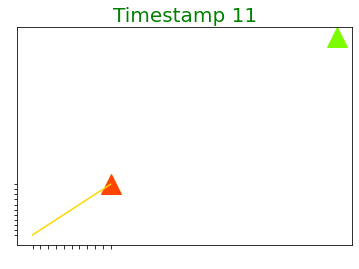

0.35000007453466103
0.6000000359614149
----------------------------------------------
12 5.200000894415722 8.200000431555226


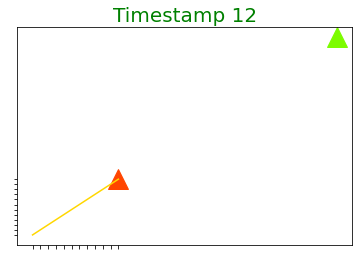

0.3500000745311563
0.600000035961227
----------------------------------------------
13 5.550000968946878 8.800000467516453


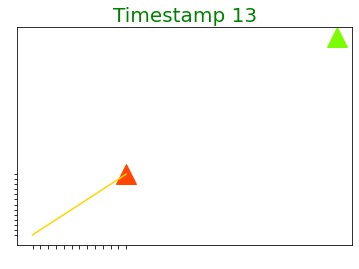

0.3500000745346262
0.6000000359610386
----------------------------------------------
14 5.900001043481504 9.400000503477491


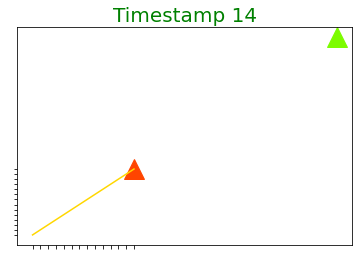

0.3500000745311563
0.6000000359612273
----------------------------------------------
15 6.25000111801266 10.000000539438718


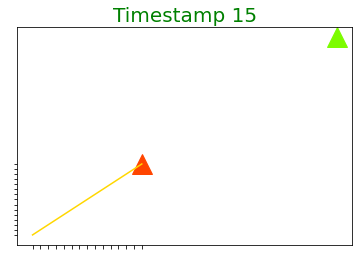

0.3500000745311562
0.6000000359610389
----------------------------------------------
16 6.600001192543816 10.600000575399756


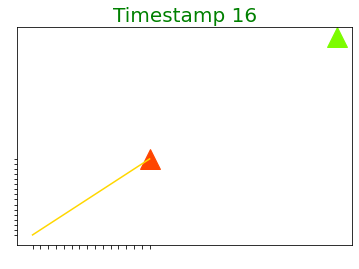

0.3500000745311553
0.6000000359612253
----------------------------------------------
17 6.950001267074971 11.20000061136098


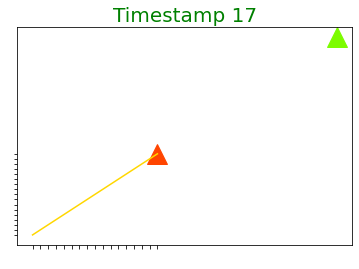

0.35000007453112075
0.600000035961225
----------------------------------------------
18 7.300001341606092 11.800000647322205


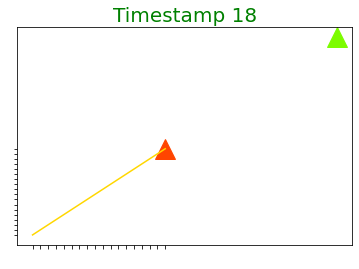

0.3500000745311554
0.6000000359424141
----------------------------------------------
19 7.650001416137247 12.40000068326462


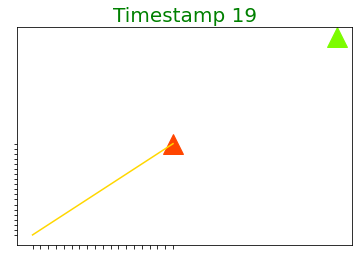

0.35000007453115567
0.600000035961226
----------------------------------------------
20 8.000001490668403 13.000000719225847


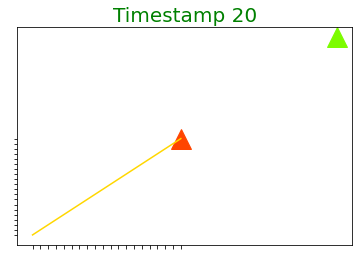

0.3500000745346259
0.6000000359424136
----------------------------------------------
21 8.350001565203028 13.60000075516826


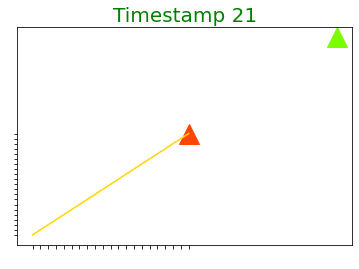

0.35000007453462506
0.6000000359424127
----------------------------------------------
22 8.700001639737653 14.200000791110673


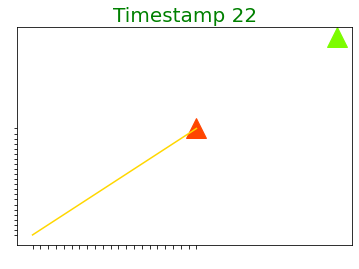

0.3500000745346599
0.6000000359424129
----------------------------------------------
23 9.050001714272314 14.800000827053086


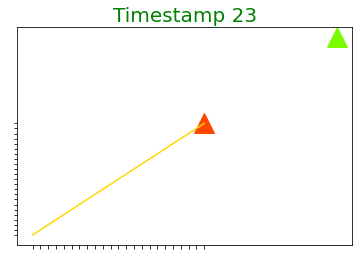

0.35000007453462495
0.6000000359424131
----------------------------------------------
24 9.40000178880694 15.4000008629955


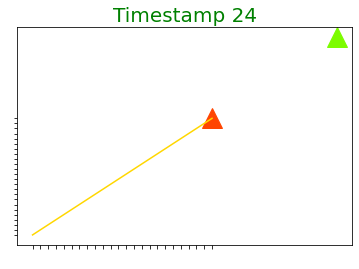

0.3500000745345907
0.6000000359424161
----------------------------------------------
25 9.75000186334153 16.000000898937916


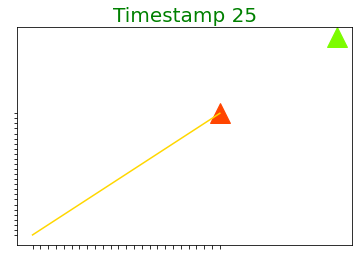

0.3500000745346255
0.6000000359424162
----------------------------------------------
26 10.100001937876156 16.60000093488033


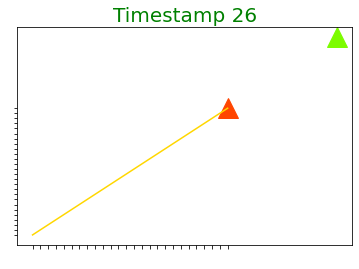

0.35000007453462545
0.6000000359424161
----------------------------------------------
27 10.450002012410781 17.200000970822746


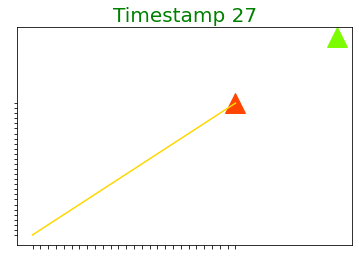

0.3500000745346255
0.6000000359424159
----------------------------------------------
28 10.800002086945407 17.80000100676516


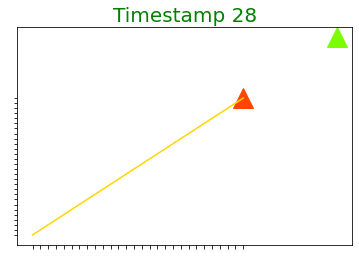

0.3500000745345906
0.6000000359612281
----------------------------------------------
29 11.150002161479996 18.400001042726387


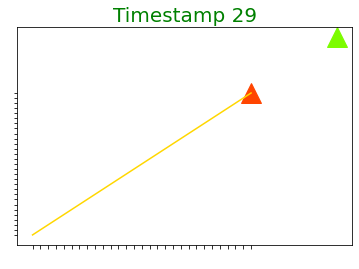

0.3500000745345906
0.6000000359424161
----------------------------------------------
30 11.500002236014588 19.000001078668802


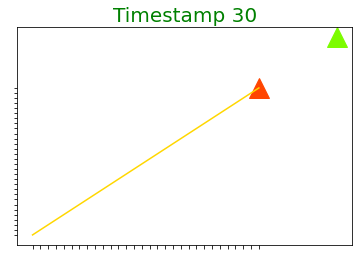

0.3500000745345907
0.6000000359612281
----------------------------------------------
31 11.85000231054918 19.60000111463003


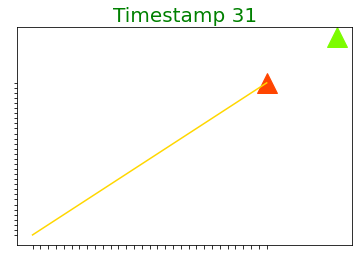

0.3500000745345908
0.6000000359424162
----------------------------------------------
32 12.20000238508377 20.200001150572444


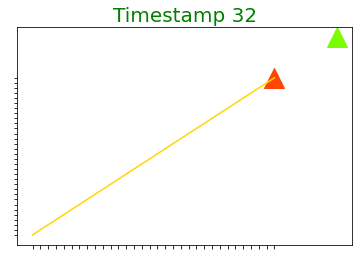

0.3500000745311206
0.6000000359424159
----------------------------------------------
33 12.550002459614891 20.80000118651486


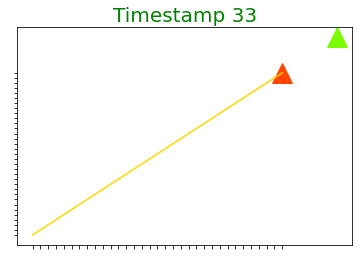

0.35000007453112036
0.6000000359424159
----------------------------------------------
34 12.900002534146012 21.400001222457274


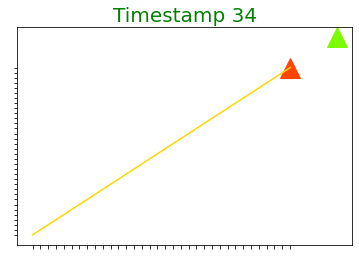

0.3500000745311206
0.600000035961228
----------------------------------------------
35 13.250002608677132 22.0000012584185


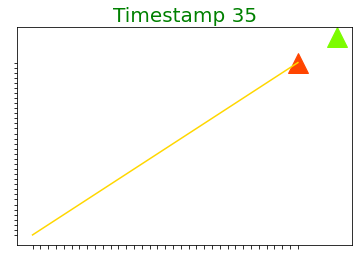

0.35000007453112025
0.6000000359612279
----------------------------------------------
36 13.600002683208253 22.600001294379727


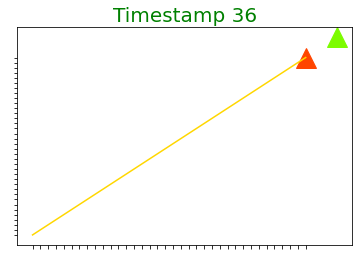

0.35000007453112036
0.6000000359612275
----------------------------------------------
37 13.950002757739373 23.200001330340953


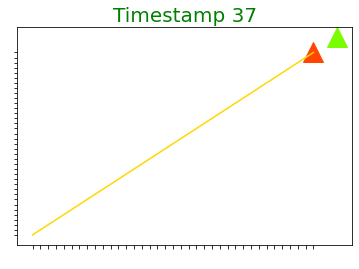

0.3500000745311205
0.6000000359612279
----------------------------------------------
38 14.300002832270494 23.80000136630218


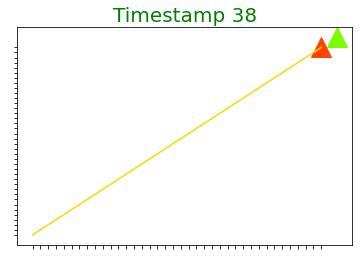

0.3500000745311206
0.6000000359612276
----------------------------------------------
39 14.650002906801614 24.400001402263406


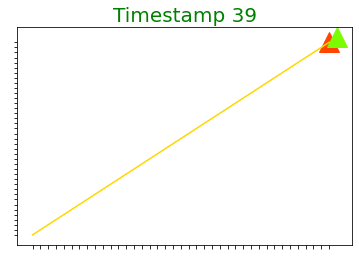

0.35000007453112036
0.6000000359612276
----------------------------------------------
40 15.000002981332734 25.000001438224633


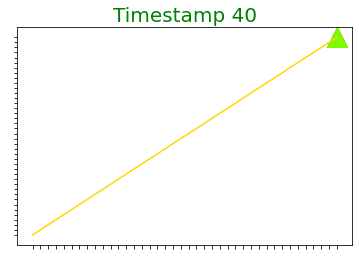

In [30]:
bot = MPC_Agent(np.array([1.0,1.0]),np.array([15.0,25.0]),40, 3)
bot.traj_opti()

## Obstacle avoidance

Robots in the real world, however, operate in much more exacting environments complete with static and dynamic actors. Obstacle avoidance is now a concern for the robot.

Below, we consider the static obstacle case, collisions are avoided by adding an obstacle avoidance constraint. The most popular method for the same is the Collision Cone constraint. 

While the collision cone constraint operates in an inertial frame of reference, depending on the application, this may not be a feasible formulation (take the example of a multi-agent dynamic system, it would be inefficient to compute and store collision cones for each pair of agents). The Velocity Obstacle is essentially the collision cone but in a non-inertial frame of reference. The ORCA constraint is useful when the task of collision avoidance is distributed amongst the agents (that is, every agent has to avoid colliding with every other obstacle as opposed to a single agent trying to avoid every obstacle). A dynamic scene with two actors can be converted into an inertial frame of reference and treated as a static obstacle avoidance problem.

In a scene with only dynamic actors, the concept of time scaling can be used in-hand with the Collision Cone / Velocity Obstacle / ORCA (Optimal Reciprocal Collision Avoidance) constraint. 

We use the collision cone formulation to add the collision avoidance constraint to our problem. It is given as: 

$$
(x_{robot} - x_{obstacle})^{2} + (y_{robot} - y_{obstacle})^{2} \geqslant R^{2}
$$

It is evident that the above constraint is non-convex - a circle, i.e. the LHS of the above equation, is a convex set. As we're searching for a point that lies outside of the convex set, our problem is no longer convex. We pass this constraint to our solver in order to obtain the navigation control inputs for the timestamp.

In [31]:
class ColCone_MPC_Agent:
    
    def __init__(self, start, goal, steps, vmax, obs):
        self.xpath = []
        self.ypath = []
        self.time = 0
        self.pos = start
        self.goal = goal
        self.v = np.array([0,0])
        self.steps = steps
        self.vmax = vmax
        self.obs = obs
        
    
    def traj_opti(self):
        
        self.xpath.append(self.pos[0])
        self.ypath.append(self.pos[1])
        if os.path.isdir("./cc_plots_temp"):
            shutil.rmtree("./cc_plots_temp")
        os.mkdir("./cc_plots_temp") 
        
        while(np.linalg.norm(self.pos - self.goal) > 0.5):
            v = cvx.Variable((2,1))
            obj = cvx.Minimize((cvx.norm(self.pos + v*t_del - self.goal))**2)
            constr = [ v[0]>=0, v[0]<= self.vmax, v[1]>=0, v[1]<=self.vmax]
            constr += [ (cvx.norm(self.pos + v*t_del - self.obs[0:2]))**2 >= (self.obs[2])**2]
            prob = cvx.Problem(obj, constr)
            #print(dccp.is_dccp(prob))
            result = prob.solve(method = 'dccp')
            print('v = ', v.value)

            self.pos[0] = self.pos[0] + v[0].value * t_del
            self.pos[1] = self.pos[1] + v[1].value * t_del
            self.xpath.append(self.pos[0])
            self.ypath.append(self.pos[1])
            self.time += 1
            print(self.time, self.pos)
 
            self.visualize_traj()
   

    def visualize_traj(self):

        fig, ax = plt.subplots(figsize = (12,12))
        
        ax.plot(self.pos[0], self.pos[1], '^',color = 'orangered', markersize = 20)
        ax.plot(self.goal[0], self.goal[1], '^',color = 'lawngreen', markersize = 20)
        a_circle = plt.Circle(xy = (self.obs[0], self.obs[1]), radius = self.obs[2], alpha = 0.7, animated = True, color = 'aqua', edgecolor = 'orange' )
        ax.set_aspect( 1 )
        ax.add_artist(a_circle)
        
        fig.suptitle("Timestamp " + str(self.time), fontsize = 20, color = 'green')
        x_path = np.array(self.xpath)
        y_path = np.array(self.ypath)
        ax.plot(x_path, y_path, color = 'gold')

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        fig.savefig("./cc_plots_temp/" + str(self.time) + ".png")

        fig.show()
 

v =  [[2.99999997]
 [2.99999999]]
1 [[3.99999997]
 [3.99999999]]
v =  [[2.99999995]
 [2.99999998]]
2 [[6.99999992]
 [6.99999997]]


<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (self.obs[0], self.obs[1]), radius = self.obs[2], alpha = 0.7, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-31-19348c66b392>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (self.obs[0], self.obs[1]), radius = self.obs[2], alpha = 0.7, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-31-19348c66b392>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


v =  [[2.99999998]
 [1.00000003]]
3 [[9.9999999]
 [8.       ]]


<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (self.obs[0], self.obs[1]), radius = self.obs[2], alpha = 0.7, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-31-19348c66b392>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


v =  [[2.99999996]
 [1.3542485 ]]
4 [[12.99999987]
 [ 9.35424849]]
v =  [[2.00016924]
 [2.99999998]]
5 [[15.00016911]
 [12.35424848]]


<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (self.obs[0], self.obs[1]), radius = self.obs[2], alpha = 0.7, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-31-19348c66b392>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (self.obs[0], self.obs[1]), radius = self.obs[2], alpha = 0.7, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-31-19348c66b392>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'colo

v =  [[3.79405742e-04]
 [2.99999997e+00]]
6 [[15.00054851]
 [15.35424845]]
v =  [[5.93427131e-04]
 [2.99999997e+00]]
7 [[15.00114194]
 [18.35424842]]


<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (self.obs[0], self.obs[1]), radius = self.obs[2], alpha = 0.7, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-31-19348c66b392>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (self.obs[0], self.obs[1]), radius = self.obs[2], alpha = 0.7, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-31-19348c66b392>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'colo

v =  [[4.04657007e-06]
 [3.00000000e+00]]
8 [[15.00114599]
 [21.35424841]]
v =  [[3.11863567e-07]
 [3.00000000e+00]]
9 [[15.0011463 ]
 [24.35424841]]


<ipython-input-31-19348c66b392>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-31-19348c66b392>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a_circle = plt.Circle(xy = (self.obs[0], self.obs[1]), radius = self.obs[2], alpha = 0.7, animated = True, color = 'aqua', edgecolor = 'orange' )
<ipython-input-31-19348c66b392>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


v =  [[2.13780480e-07]
 [6.45747666e-01]]
10 [[15.00114651]
 [24.99999608]]


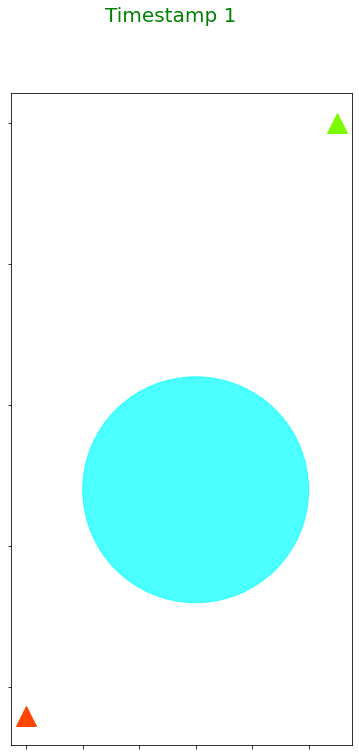

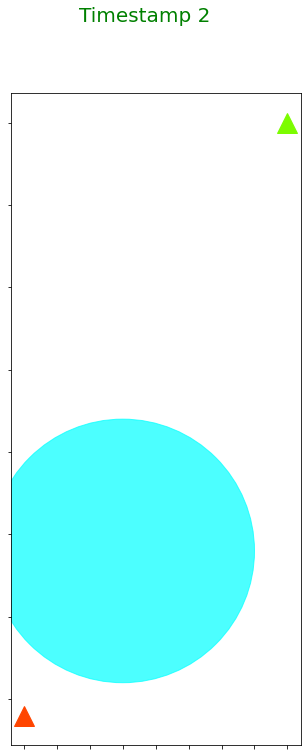

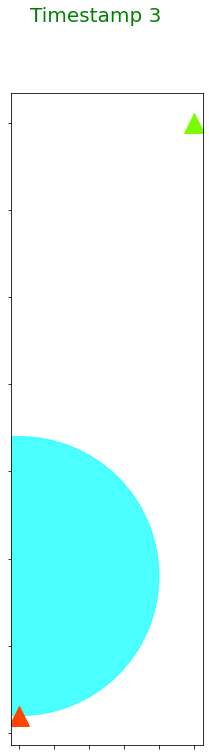

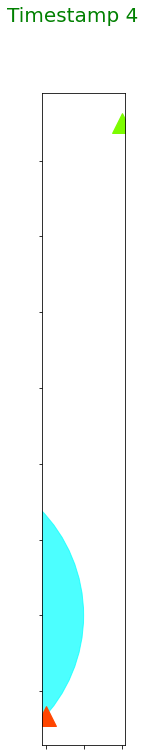

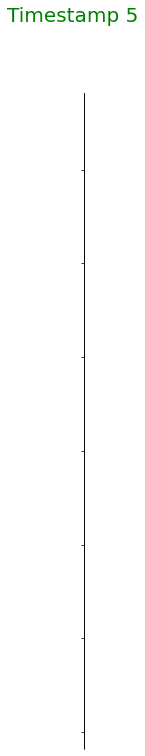

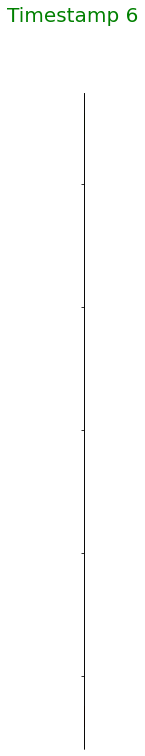

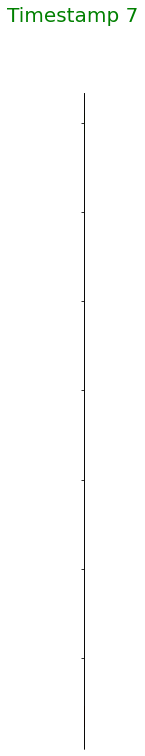

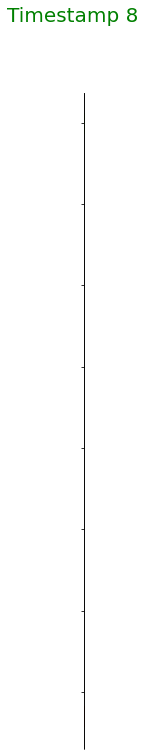

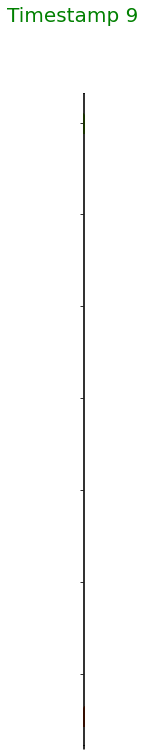

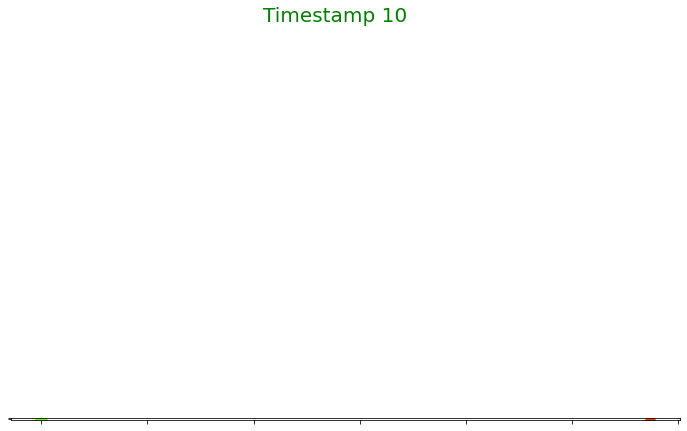

In [32]:
bot = ColCone_MPC_Agent(np.array([1.0,1.0]).reshape((2,1)),np.array([15.0,25.0]).reshape((2,1)),40, 3, np.array([10,12,4]).reshape((3,1)))
bot.traj_opti()